<a href="https://colab.research.google.com/github/jefernandezec/s2s/blob/main/S2S.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fundamentals of Survey-to-Survey Imputation

**1. Creating a dataset with a model-based consumption per capita**

Set seed for reproducibility and simulate raw variables

In [16]:
set.seed(1729)
n <- 1000

age             <- sample(18:79, n, replace = TRUE)
age_sq          <- age^2
house_ownership <- rbinom(n, 1, 0.6)   # 1 = owns house
employed    <- rbinom(n, 1, 0.7)   # 1 = employed
electricity     <- rbinom(n, 1, 0.8)   # 1 = has electricity
wallsbrick <- rbinom(n, 1, 0.75)   # 1 = walls material: brick
roofmetal  <- rbinom(n, 1, 0.25)   # 1 = roof material: brick
floordirt  <- rbinom(n, 1, 0.15)   # 1 = floor material: dirt
areaurban  <- rbinom(n, 1, 0.65)   # 1 = urban

df <- data.frame(
  age, age_sq, house_ownership, employed, electricity,
  wallsbrick,roofmetal,floordirt,areaurban
)

Define "actual" coefficients

In [17]:
base_coeffs <- c(
  age             = 0.3,
  age_sq          = -0.002,
  house_ownership = 5,
  employed    = 10,
  electricity     = 8,
  wallsbrick     =3,
  roofmetal     = 4,
  floordirt     = -5,
  areaurban    =7
)

Simulate normal random noise and create per capita consumption

In [18]:
noise=rnorm(n,sd=3) #alternative for normal noise
#noise=rexp(n, rate = 1/10) - 10
base_coeffs = matrix(base_coeffs,ncol=1)

#df$consumption_pc=exp(B_0 + as.matrix(df)%*%base_coeffs+noise) #alternative for normal noise
df$consumption_pc=as.matrix(df)%*%base_coeffs+noise

head(df)

,age,age_sq,house_ownership,employed,electricity,wallsbrick,roofmetal,floordirt,areaurban,consumption_pc
,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,"<dbl[,1]>"
1,36,1296,1,1,1,0,0,0,1,35.24686
2,75,5625,1,0,0,0,1,0,0,20.13671
3,59,3481,0,0,1,0,0,0,1,25.08408
4,62,3844,1,0,1,1,1,0,0,33.40781
5,78,6084,1,1,1,0,0,0,0,33.25129
6,60,3600,1,0,1,0,0,1,0,12.24551


Visualize the density plot

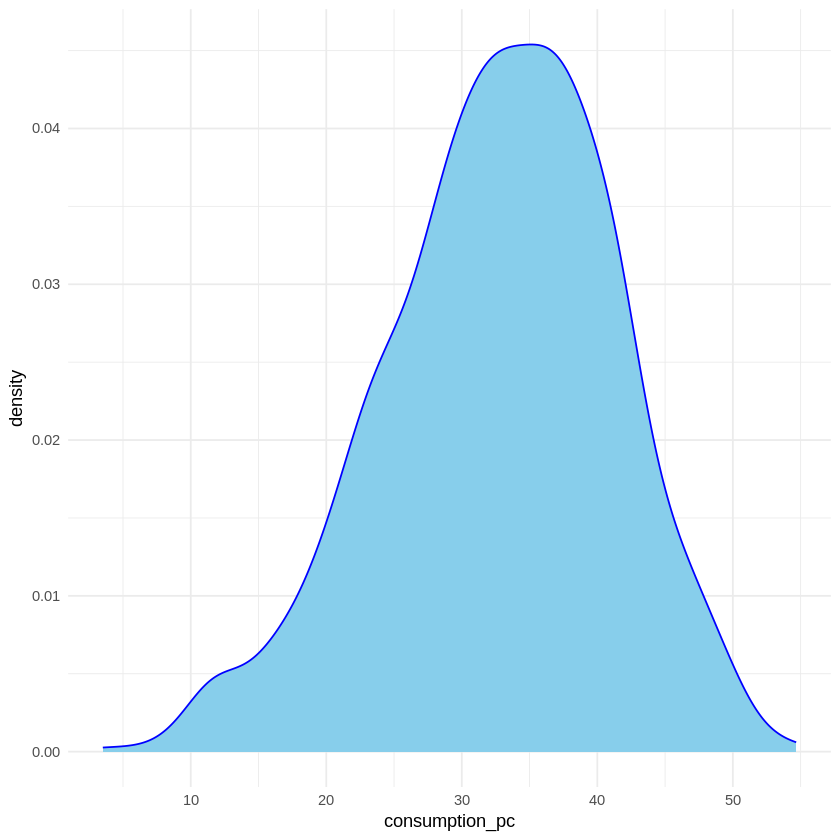

In [19]:
library(ggplot2)

ggplot(df, aes(x = consumption_pc)) +
  geom_density(fill = "skyblue", color = "blue") +
  theme_minimal()

Adjust linear model for consumption_pc

In [20]:
mod0=lm(consumption_pc ~ . , df)
summary(mod0)


Call:
lm(formula = consumption_pc ~ ., data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.5917 -1.9928 -0.0536  2.1635  9.5248 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      1.7979160  0.8296880   2.167   0.0305 *  
age              0.2389638  0.0336589   7.100 2.39e-12 ***
age_sq          -0.0013967  0.0003419  -4.085 4.76e-05 ***
house_ownership  5.2362681  0.2001799  26.158  < 2e-16 ***
employed         9.9489958  0.2138632  46.520  < 2e-16 ***
electricity      7.6898562  0.2368802  32.463  < 2e-16 ***
wallsbrick       3.0570116  0.2311034  13.228  < 2e-16 ***
roofmetal        3.6582953  0.2234341  16.373  < 2e-16 ***
floordirt       -5.4458786  0.2675934 -20.351  < 2e-16 ***
areaurban        6.9741518  0.2087172  33.414  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.11 on 990 degrees of freedom
Multiple R-squared:  0.866,	Adjusted R-squared:  0.8648 
F-statisti

Visualize residuals

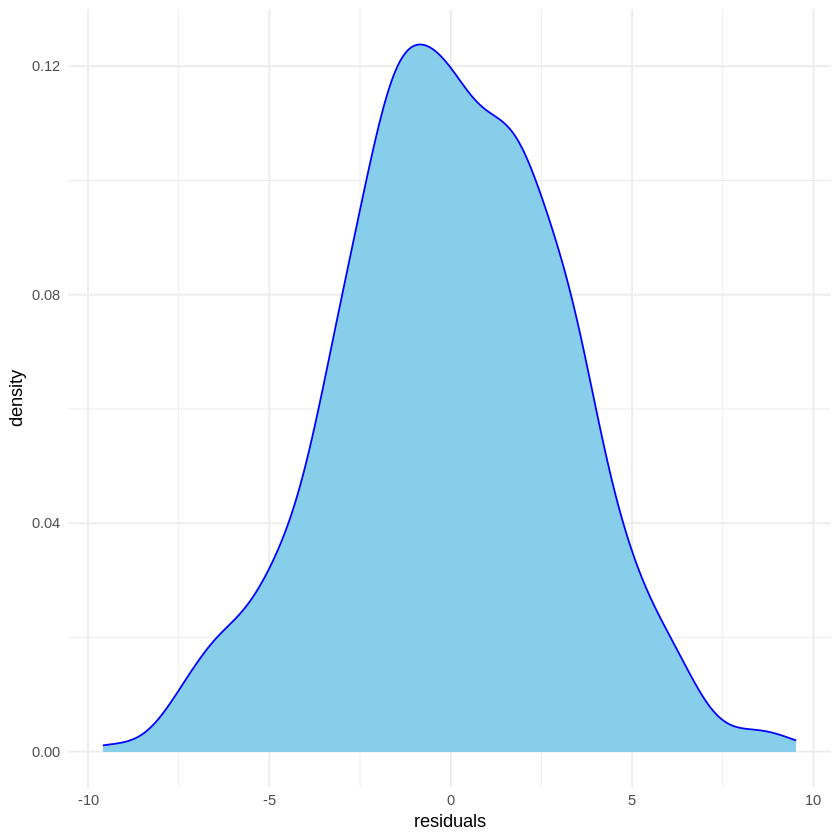

In [21]:
df$residuals = mod0$residuals

ggplot(df, aes(x = residuals)) +
  geom_density(fill = "skyblue", color = "blue") +
  theme_minimal()


How does the prediction look compared to the actual distribution?

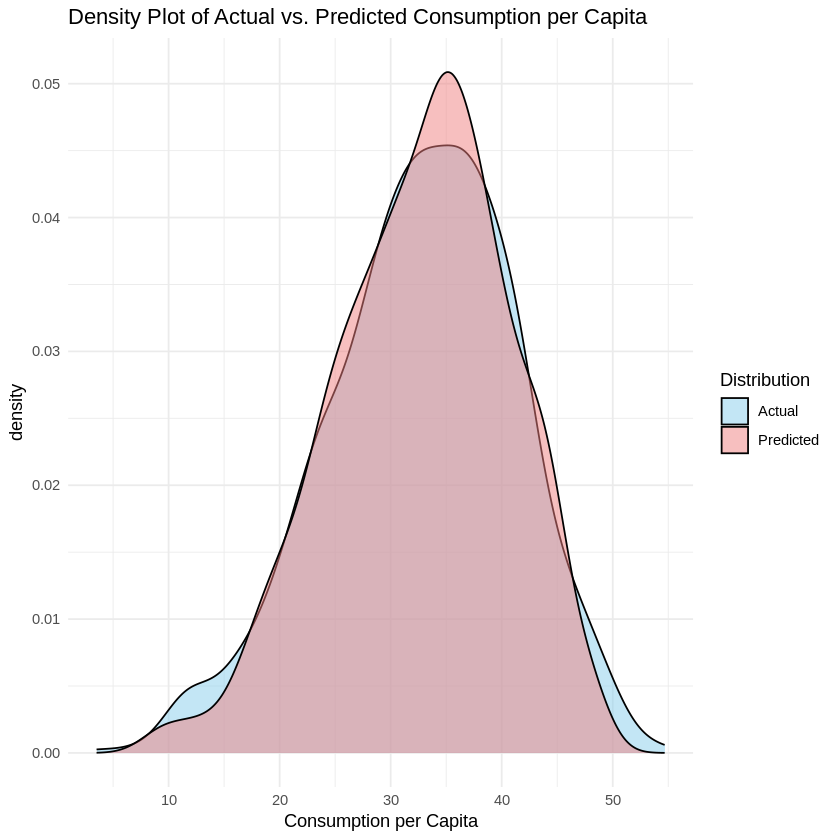

In [27]:
df$predicted <- predict(mod0)

ggplot(df, aes(x = consumption_pc)) +
  geom_density(aes(fill = "Actual"), alpha = 0.5) +
  geom_density(aes(x = predicted, fill = "Predicted"), alpha = 0.5) +
  scale_fill_manual(values = c("Actual" = "skyblue", "Predicted" = "lightcoral")) +
  theme_minimal() +
  labs(title = "Density Plot of Actual vs. Predicted Consumption per Capita",
       x = "Consumption per Capita",
       fill = "Distribution")

More realistic: dropping a **few** covariates

In [36]:
mod1=lm(consumption_pc ~ age+age_sq+areaurban +electricity+house_ownership+roofmetal, df)
summary(mod1)


Call:
lm(formula = consumption_pc ~ age + age_sq + areaurban + electricity + 
    house_ownership + roofmetal, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-20.0312  -3.9398   0.9424   4.4657  14.0772 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      9.9416780  1.5183043   6.548 9.35e-11 ***
age              0.2492822  0.0647387   3.851 0.000125 ***
age_sq          -0.0014861  0.0006576  -2.260 0.024045 *  
areaurban        7.2199752  0.4011808  17.997  < 2e-16 ***
electricity      7.7184856  0.4559523  16.928  < 2e-16 ***
house_ownership  5.0094682  0.3851284  13.007  < 2e-16 ***
roofmetal        3.2795161  0.4294838   7.636 5.26e-14 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 5.986 on 993 degrees of freedom
Multiple R-squared:  0.5019,	Adjusted R-squared:  0.4989 
F-statistic: 166.8 on 6 and 993 DF,  p-value: < 2.2e-16


Visualize residuals

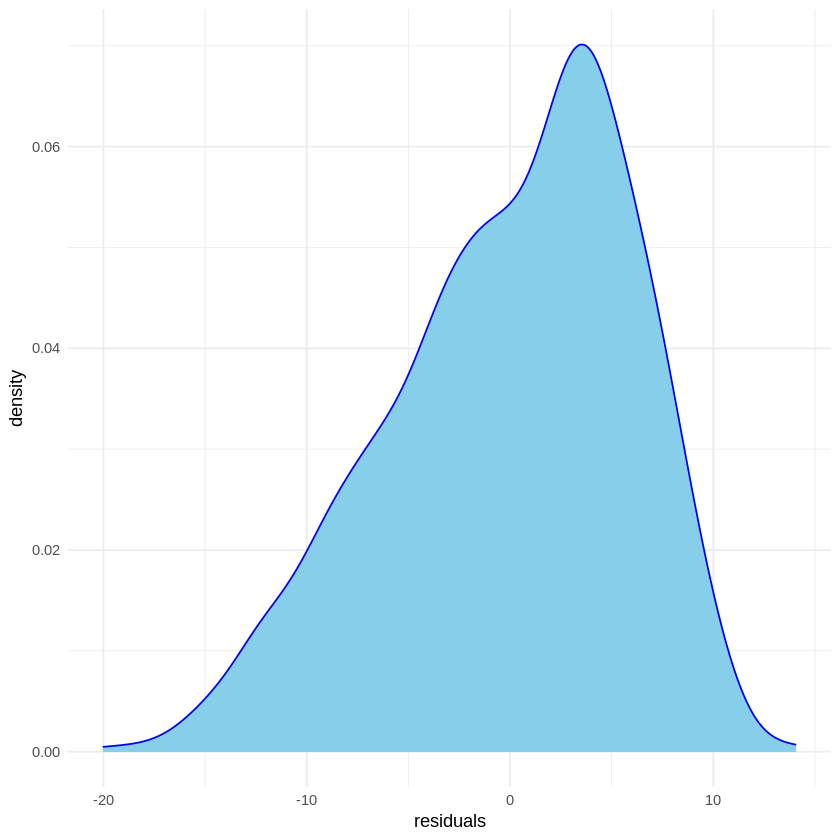

In [51]:
df$residuals = mod1$residuals

ggplot(df, aes(x = residuals)) +
  geom_density(fill = "skyblue", color = "blue") +
  theme_minimal()

And the prediction...

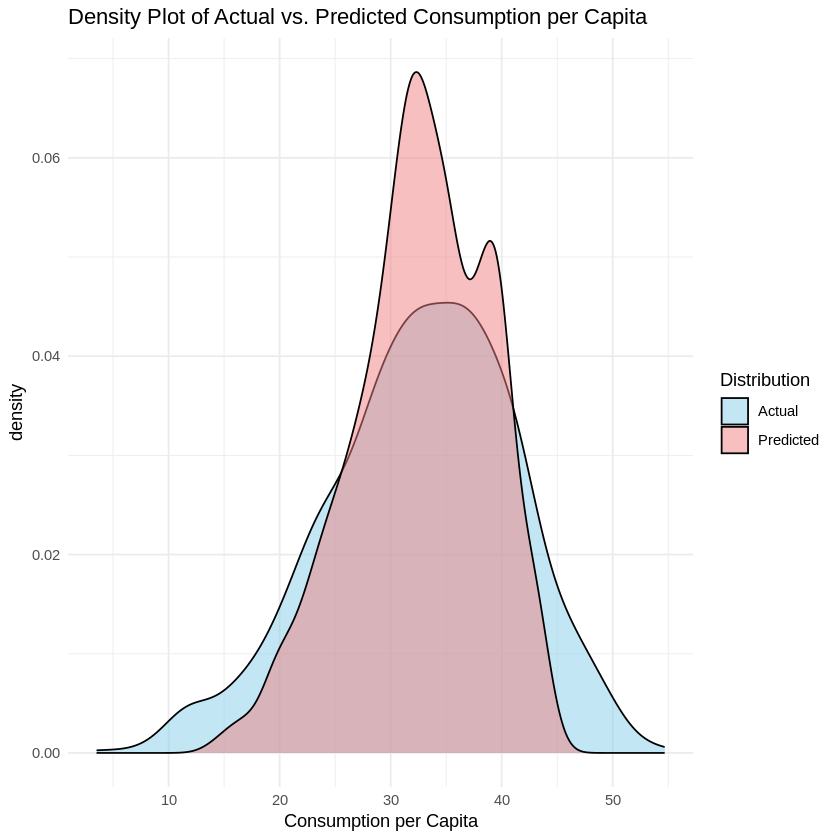

In [52]:
df$predicted <- predict(mod1)

ggplot(df, aes(x = consumption_pc)) +
  geom_density(aes(fill = "Actual"), alpha = 0.5) +
  geom_density(aes(x = predicted, fill = "Predicted"), alpha = 0.5) +
  scale_fill_manual(values = c("Actual" = "skyblue", "Predicted" = "lightcoral")) +
  theme_minimal() +
  labs(title = "Density Plot of Actual vs. Predicted Consumption per Capita",
       x = "Consumption per Capita",
       fill = "Distribution")

Estimating poverty rate. Assume poverty line = 32.

In [54]:
# Actual
cat("Actual poverty rate: ",mean(df$consumption_pc<32),"\n")

# Predicted
cat("Predicted poverty rate: ",mean(df$predicted<32))

Actual poverty rate:  0.438 
Predicted poverty rate:  0.43

Good enough. What if poverty line = 27

In [56]:
# Actual
cat("Actual poverty rate: ",mean(df$consumption_pc<27),"\n")

# Predicted
cat("Predicted poverty rate: ",mean(df$predicted<27))

Actual poverty rate:  0.24 
Predicted poverty rate:  0.168

Uh-oh. Something went wrong. Let's see.

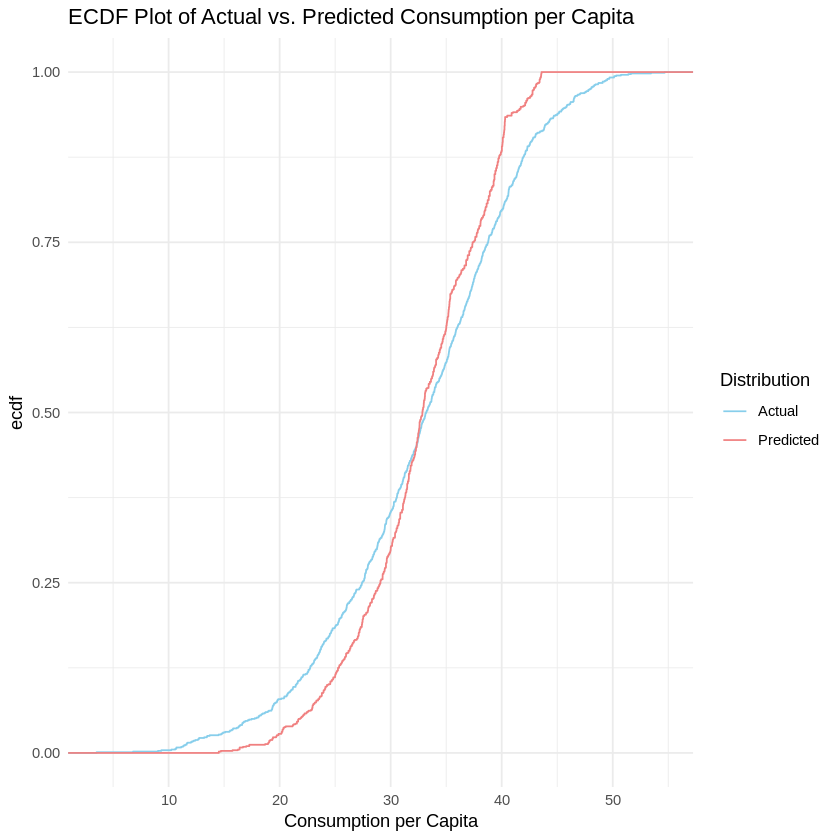

In [57]:
ggplot(df, aes(x = consumption_pc)) +
  stat_ecdf(aes(color = "Actual")) +
  stat_ecdf(aes(x = predicted, color = "Predicted")) +
  scale_color_manual(values = c("Actual" = "skyblue", "Predicted" = "lightcoral")) +
  theme_minimal() +
  labs(title = "ECDF Plot of Actual vs. Predicted Consumption per Capita",
       x = "Consumption per Capita",
       color = "Distribution")